In [1]:
import os
import time
import datetime
import glob
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scprep
import graphtools as gt
import phate
from scipy import sparse
from scipy.stats import zscore 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import warnings
from adjustText import adjust_text
import sys
sys.path.append('/home/ngr4/project/scripts/')
import utils

In [2]:
pdfp = '/home/ngr4/project/sccovid/data/processed'
pfp = '/home/ngr4/project/sccovid/results/'

adata = utils.load_adata(os.path.join(pdfp,'ats.h5ad'))

loaded @200622.21:22:57
took 0.28-s to load data


In [12]:
genes = {'Ciliated-DGE':['MALAT1','SCGB1A1','JUN','S100A2','SOX4','SCGB3A1','SERPINB3',
                         'NFKBIA','EGR1','FOS','HES1','TXNIP','PMAIP1','SQSTM1',
                         'ATF3','TMEM190','LGALS3','TSPAN1','C20orf85','C9orf24',
                         'TUBA1A','GSTP1','DYNLL1','HSP90AA1','FTH1','PRDX5',
                         'TUBB4B','S100A11','CAPS','S100A6'],
         'HBEC-immune':['IFNL1','IFNAR1','IFNLR1','IFI27','IFITM3','IFI6','IFIT1', 
                             'MX1','ISG15','CCL2','CXCL9','CXCL10','CXCL11','CXCL16','IL1A','IL1B','IL1RN','IL6','IL10','TNF',],
         'HBEC-viral':['scv2_orf1-10','ACE','ACE2','TMPRSS2','TMPRSS4','CTSL',
                          'CLTRN','DPP4','ANPEP'],
        }

# limited gene list
genes = {
  'Ciliated-DGE': ['S100A6',
  'SOX4',
  'MALAT1',
  'NFKBIA',
  'CAPS',
  'FTH1',
  'C9orf24',
  'S100A11',
  'GSTP1',
  'EGR1',
  'HSP90AA1',
  'HES1',
  'TUBA1A',
  'LGALS3',
  'PRDX5',
  'DYNLL1',
  'SCGB3A1',
  'SQSTM1',
  'FOS',
  'JUN',
  'TSPAN1',
  'PMAIP1',
  'TUBB4B',
  'TXNIP',
  'S100A2',
  'ATF3'],
 'HBEC-immune': ['IFNLR1',
  'IFI6',
  'IL1B',
  'IFIT1',
  'CXCL16',
  'IFI27',
  'IL6',
  'IFNAR1',
  'TNF',
  'CXCL10',
  'IFITM3',
  'IL1RN',
  'MX1',
  'ISG15',
  'IL1A'],
 'HBEC-viral': ['TMPRSS2',
  'CTSL',
  'DPP4',
  'CLTRN',
  'ACE2',
  'TMPRSS4',
  'scv2_orf1-10']}

missing = utils.marker_check(genes, adata)
if False:
    # drop the cell_markers missing
    for k in genes.keys():
        if k in missing.keys():
            new_markers = list(set(genes[k]) - set(missing[k]))
            if len(new_markers)>0:
                genes[k] = new_markers

        else:
            genes[k] = genes[k]
    print(genes)

All markers in data.


In [13]:
adata.obs['Infected'] = adata.obs['scv2_geq1'].map({1:'Infected', 0:'Bystander'})
adata.obs.loc[adata.obs['Condition']=='Mock', 'Infected'] = 'Mock'
adata.obs['Infected'] = adata.obs['Infected'].astype('category')

# Heatmaps

In [25]:
sns.set(font_scale=2)

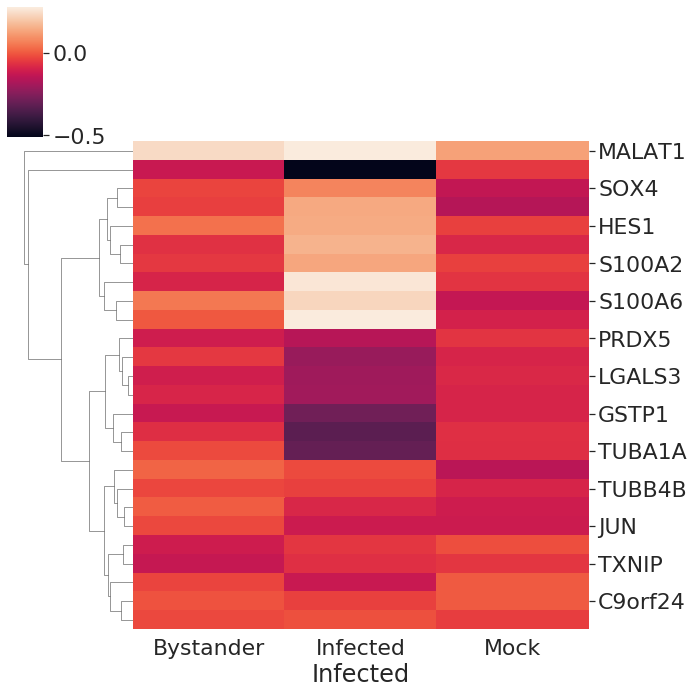

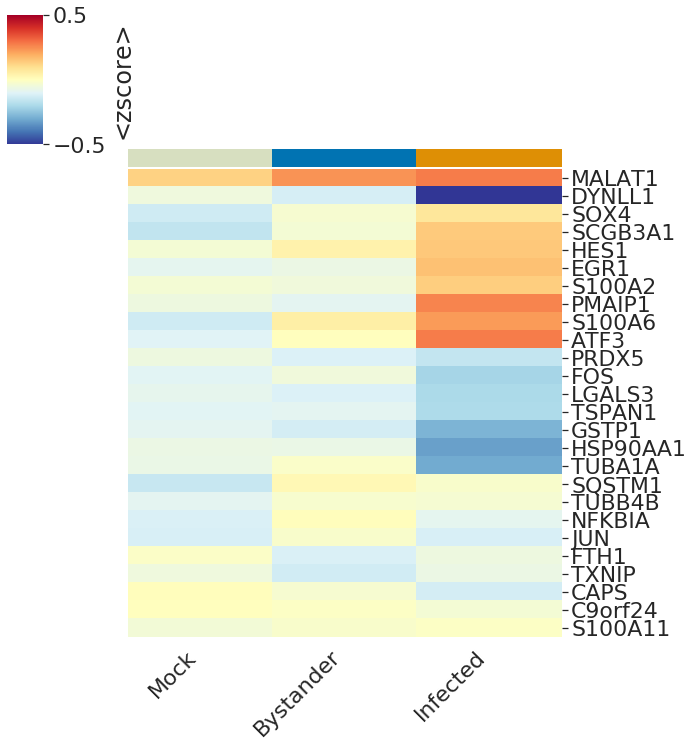

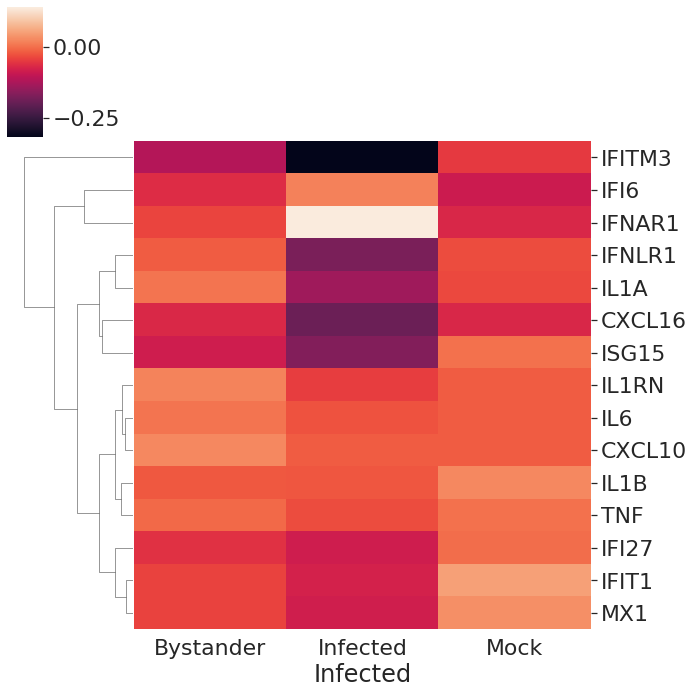

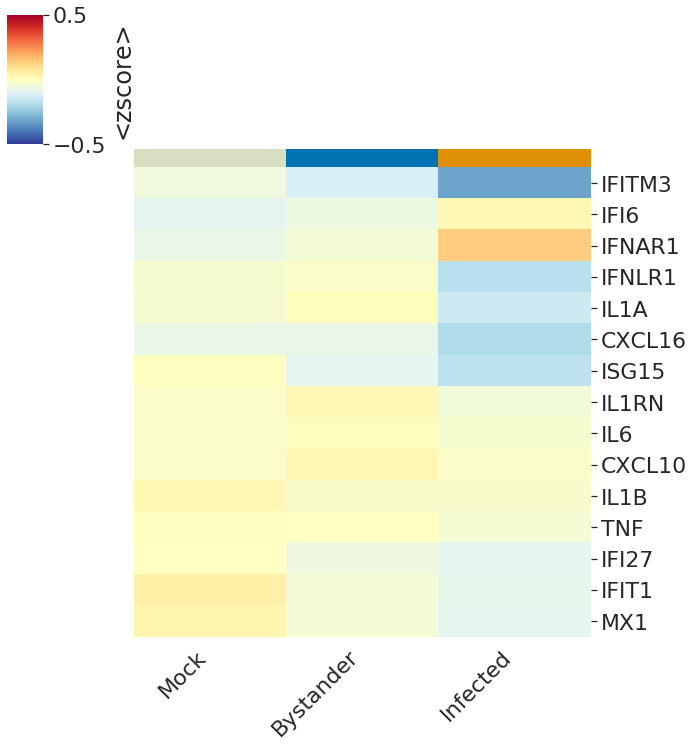

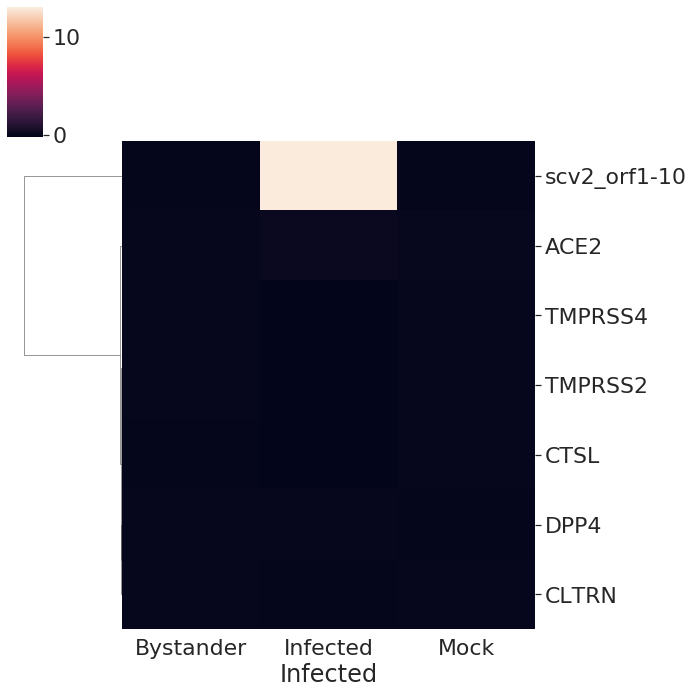

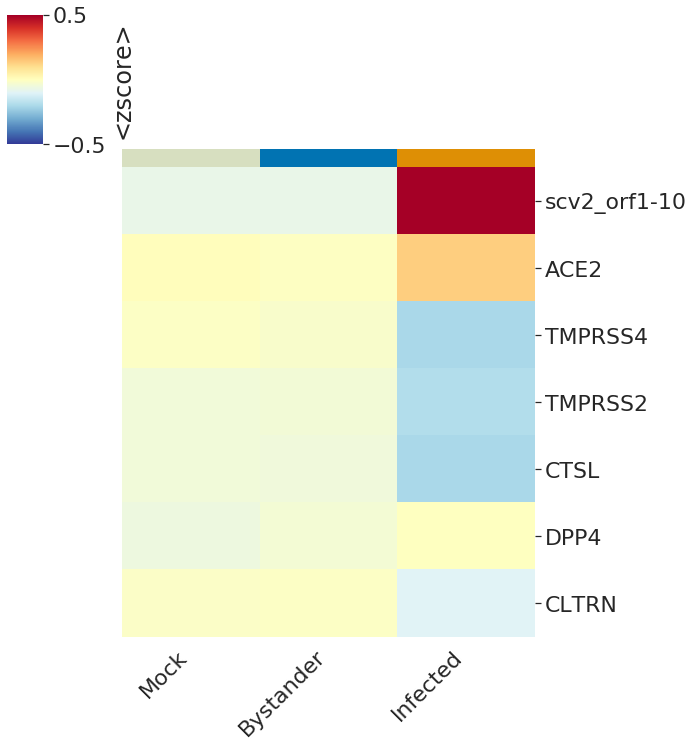

In [26]:
cmap_infected = {'Mock':sns.cubehelix_palette(4, start=.5, rot=-.75)[0],
                 'Bystander':sns.color_palette('colorblind')[0],
                 'Infected':sns.color_palette('colorblind')[1]}

for ctype in ['AT2']: #[None]    
    for fname in genes.keys():
        # construct dataframe
        X = pd.DataFrame(np.asarray(adata[:,genes[fname]].X.todense()), 
                        columns=genes[fname])
        X['Cell type'] = adata.obs['init_ctype'].astype(str).to_list()
        X['Infected'] = adata.obs['Infected'].astype(str).to_list()

        x = X
        x.loc[:,genes[fname]] = zscore(x.loc[:,genes[fname]])
        x = x.loc[x['Cell type']==ctype,:]

        ave_zscore = x.groupby(['Infected']).mean().T

        # drop na 
        ave_zscore = ave_zscore.dropna()
        # get cluster order 
        p0 = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
        )
        ave_zscore = ave_zscore.reindex(ave_zscore.index[p0.dendrogram_row.reordered_ind])
        
        order = ['Mock', 'Bystander', 'Infected']
        
        for i in order:
            if i not in ave_zscore.columns.to_list():
                ave_zscore[i] = np.nan

        #### MODIFY manually
        ave_zscore = ave_zscore[order]
        
        if False:
            # insert gaps 
            ave_zscore['1'] = np.nan
            ave_zscore['2'] = np.nan
            ave_zscore = ave_zscore[['CTRL', '1',
                                     'Extubated Pt 1', 
                                     '2','Intubated Pt 1']]

        p = sns.clustermap(
            ave_zscore,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
        #     figsize=(2,8),
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            col_linkage=None,
            row_colors=None,
            col_colors=list(map(cmap_infected.get, order)),
            mask=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            cbar_kws={'label':'<zscore>','ticks':[-0.5,0.5]},
            vmin=-0.5,vmax=0.5,
        )
#         p.ax_heatmap.set_xticklabels(['CTRL', '',
#                                      'Extubated Pt 1',  
#                                      '','Intubated Pt 1'], rotation=45, ha='right')
        p.ax_heatmap.set_xticklabels(order, rotation=45, ha='right')
        p.ax_heatmap.set_xlabel('')
        if True:
            p.savefig(os.path.join(pfp,'heatmap_{}_{}.png'.format(fname.replace(' ',''),ctype.replace('/','-'))),dpi=300,bbox_inches='tight')